<a href="https://colab.research.google.com/github/bieri2/ATMS597-Project2-GroupA/blob/master/groupa_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ATMS 597 Group A - Carolina Bieri, Arka Mitra, and Jesse Loveridge
## Assignment 2

## Import modules

In [0]:
# Import necessary modules
import numpy as np
import requests
import pandas as pd
import calendar
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from   matplotlib.pyplot import cm
import matplotlib as mpl

## Define helper functions

In [0]:
# Define function to download data from NCEI
# Function adapted from Stefanie Moline: https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/

def make_request(endpoint, token, payload=None):
    """
    Make a request to a specific endpoint on the NCDC Web API
    passing headers and optional payload.
    
    Parameters:
        - endpoint : The endpoint of the API you want to 
                    make a GET request to (string).
        - token : User-specific access token from NCEI (string)
        - payload : A dictionary of data to pass along 
                   with the request.
    
    Returns:
        Response object.
    """
    return requests.get(
        f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
        headers={
            'token': token 
        },
        params=payload
    )

In [0]:
def stripes_inputs(stationid, token, start, end):
    """
    A Python function that takes in a station ID, start year, and
    end year and downloads the necessary data from
    the Global Historical Climatology Network.
    
    Parameters:
        - stationid (string) : Station ID.
        - token (string) : User-specific access token from NCEI.
        - start (integer) : Start year.
        - end (integer) : End year.
    
    Returns:
        GHCN dataset as specified that can then be read as a dataframe.
    """ 
    
    # Define empty list
    results = []
    for i in range(start, end):
        print('fetching data for ' + str(i))
        response = make_request(
                  'data', token, 
                   {
                  'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
                  'stationid' : f'{stationid}', # Input station ID
                  'startdate' : datetime.date(i, 1, 1), # Input start date as Datetime object
                  'enddate'   : datetime.date(i, 12, 31), # Input end date as Datetime object
                  'datatypeid': ['TMAX', 'TMIN'], # Input requested variables
                  'units'     : 'metric', 
                  'limit'     : 1000
                   }
          )

        if response.ok:
            # we extend the list instead of appending to avoid getting a nested list
            try:
                results.extend(response.json()['results'])
            except KeyError:
                print('No results for this year: ' + str(i))
                continue

    return results

In [0]:
## Method to plot Climate (Warming) Stripes and/or Time Series (if asked) :
def plot_stripes(df, station_name, tunit, plot_tseries = 'n', save_plot = False):
    """
    A Python function that takes in max/min data for a given station and 
    plots Climate Stripes and/or Time-Series, if user asks for one.

    The Climate Stripes were created by Ed Hawkins at the University of Reading: https://showyourstripes.info/
    This function follows the procedure for creating Climate Stripes as described here: https://showyourstripes.info/faq
    
    Parameters:
        - df (DataFrame) : Pandas DataFrame which includes minimum and maximum temperature values.
                          The DataFrame should have columns named 'TMAX' and 'TMIN', as well as a Datetime index.
        - station_name (string) : String name of the Station.
        - tunit (string) : Time unit for temporal average to be applied to data before plotting.
                          Possible values are 'Y' for year (annual average), 'M' for month (monthly average), 
                          and 'W' for week (weekly average).
        - plot_tseries (string) : Character variable with user choice for either
                                  plotting or not plotting Time-series line. Either 'y' or 'n'.
    
    Returns:
        Output Image as either a Climate Stripes with/without a time series.
    """  
    ## call figure and define plot titles
    plt.figure(figsize = (20, 10))
    plt.title(station_name, fontsize = 14)

    ## Use seaborn to make nice plots
    sns.set(style = 'white')

    ## Resample data to desired frequency and take mean at that frequency
    df = df.resample(tunit).mean()

    t     = df.index
    num_t = len(t)

    ## Get data for 1970-2000 - will be used for baseline average
    df_base    = df[(t.year <= 2000) & (t.year >= 1970)]

    ## Calculate mean between TMAX and TMIN for whole period
    AvT        = df[['TMAX', 'TMIN']].mean(axis = 1)
    ## Calculate baseline average from 1970-2000
    AvT_base   = df_base[['TMAX', 'TMIN']].mean(axis = 1).mean()
    ## Calculate standard deviation for whole period
    AvT_stddev = AvT[AvT.index.year <= 2000].std()
    
    ## Calculate anomalies using baseline average
    Tanoms = (AvT.values - AvT_base)/AvT_stddev

    ## Create dummy array to use for line graph 
    X = np.arange(num_t)

    ## Plot stripes and time-series if necessary :  
    ## Use standard deviation to scale colors 
    plt.imshow(Tanoms[np.newaxis, :], origin = 'lower', 
               extent = (min(X), max(X), min(AvT)-5, max(AvT)+5), 
               cmap = 'seismic', vmin = (-2.6), vmax = (2.6))
    ## Add line plot and axes if user requests it
    if (plot_tseries == 'y'):
        plt.plot(X,  AvT, marker = 'o', color = 'yellow') 
        plt.ylim(min(AvT) - 2.5, max(AvT) + 2.5)
        plt.ylabel('Average temperature ($\degree C$)')
        plt.xlabel('Year')
        if tunit == 'Y':
            plt.xticks(X[::10], t[::10].strftime("%Y"))
        elif tunit == 'M':
            plt.xticks(X[::100], t[::100].strftime("%Y"))
        else:
            plt.xticks(X[::200], t[::200].strftime("%Y"))
        plt.colorbar(shrink = 0.3, label = 'Std. dev.')
    else:
        plt.axis('off') # Default is to suppress the axes
 
    plt.show()

    if save_plot:
        ## Save figure as .png
        plt.savefig(station_name + '_ClimateStripes_' + str(start) + '_' + 
                    str(end) + '.png', bbox_inches = 'tight', dpi = 400)

In [0]:
def make_dataframe(data):
    '''
    This function take the input data and returns a DataFrame for the purpose of 
    computing mean values and creating a Climate Stripes graph. 

    Parameters:
        - data (list) : A list of dictionaries with TMAX and TMIN data returned from the stripes_inputs function.

    Returns: 
        - df (DataFrame) : A pandas DataFrame with a DateTime index and TMAX and TMIN columns to be used to plot 
                 Climate Stripes.
    '''
    ## Create temporary data-frame with all data:
    df_temp = pd.DataFrame(data)
    ## Set date column as index
    df_temp = df_temp.set_index(pd.to_datetime(df_temp['date'])).drop(columns = 'date')
    ## Define new DataFrame with only TMAX and fill in missing values by resampling
    df = df_temp[df_temp['datatype'] == 'TMAX'].resample('D').asfreq()
    ## Rename the 'value' column as 'TMAX'
    df = df.rename(columns = {'value':'TMAX'})
    ## Add TMIN data to DataFrame from temporary DataFrame
    df['TMIN'] = df_temp[df_temp['datatype'] == 'TMIN'].resample('D').asfreq()['value']

    return df

## Example with data from Utah and New York

In [18]:
## Execute code below if this is the main script
if __name__ == '__main__':

    ## Define user-specific token
    token        = 'fqMFYJqPpWnQIARJzXBQhWPbYEtJwpoH'

    ## Define start and end times
    starttime_ut = 1903
    endtime_ut   = 2020

    ## Define station ID
    stationid_ut = 'GHCND:USC00424856' # Random station in Utah
    ## Read in data from GHCN
    data_ut      = stripes_inputs(stationid_ut, token, starttime_ut, endtime_ut)
    ## Make properly formatted DataFrame
    df_ut        = make_dataframe(data_ut)



    ## Define start and end times
    starttime_ny = 1949
    endtime_ny   = 2020

    ## Define station ID
    stationid_ny = 'GHCND:USW00094790' # Random station in New York
    ## Read in data from GHCN
    data_ny      = stripes_inputs(stationid_ny, token, starttime_ny, endtime_ny)
    df_ny        = make_dataframe(data_ny)

fetching data for 1903
fetching data for 1904
fetching data for 1905
fetching data for 1906
fetching data for 1907
fetching data for 1908
fetching data for 1909
fetching data for 1910
fetching data for 1911
fetching data for 1912
fetching data for 1913
fetching data for 1914
fetching data for 1915
fetching data for 1916
fetching data for 1917
fetching data for 1918
fetching data for 1919
fetching data for 1920
fetching data for 1921
fetching data for 1922
fetching data for 1923
fetching data for 1924
fetching data for 1925
fetching data for 1926
fetching data for 1927
fetching data for 1928
fetching data for 1929
fetching data for 1930
fetching data for 1931
fetching data for 1932
fetching data for 1933
fetching data for 1934
fetching data for 1935
fetching data for 1936
fetching data for 1937
fetching data for 1938
fetching data for 1939
fetching data for 1940
fetching data for 1941
fetching data for 1942
fetching data for 1943
fetching data for 1944
fetching data for 1945
fetching da

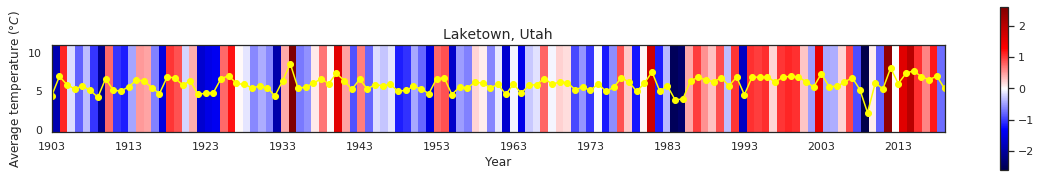

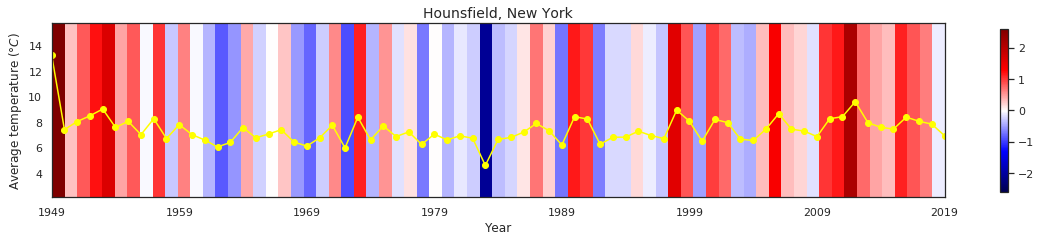

In [87]:
## Plot climate stripes at specified frequency and station
plot_stripes(df_ut, station_name = 'Laketown, Utah', tunit = 'Y', plot_tseries = 'y')
plot_stripes(df_ny, station_name = 'Hounsfield, New York', tunit = 'Y', plot_tseries = 'y')

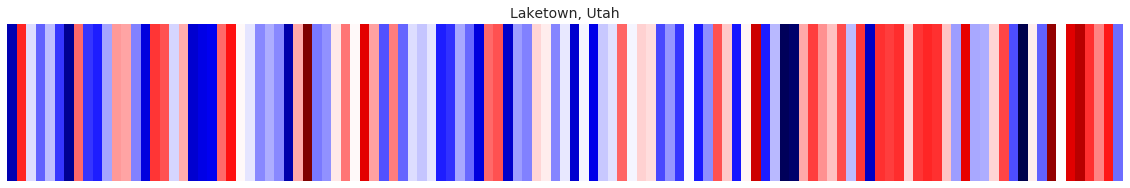

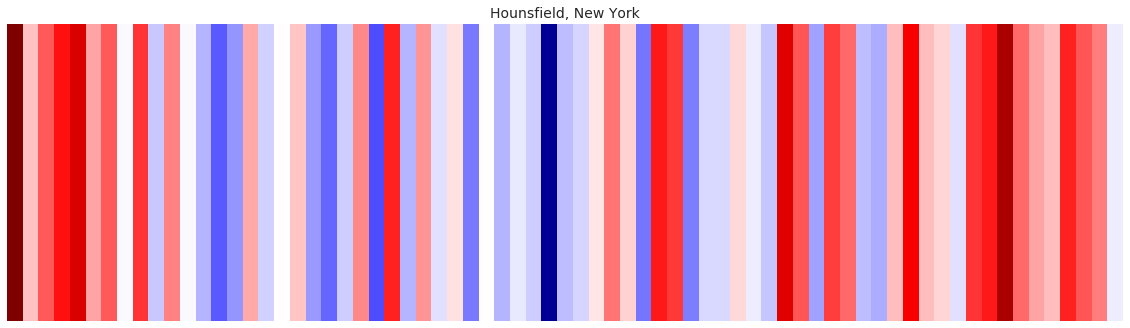

In [88]:
## Plot climate stripes at specified frequency and station
plot_stripes(df_ut, station_name = 'Laketown, Utah', tunit = 'Y', plot_tseries = 'n')
plot_stripes(df_ny, station_name = 'Hounsfield, New York', tunit = 'Y', plot_tseries = 'n')

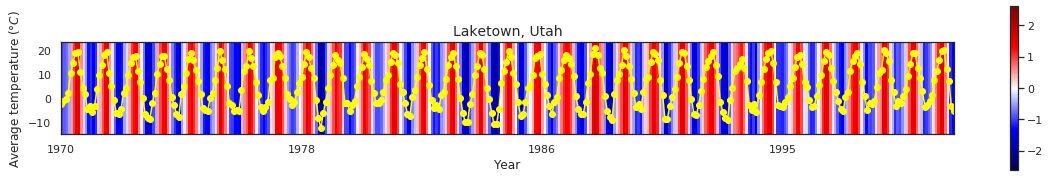

In [89]:
## Plot climate stripes at specified frequency and station
plot_stripes(df_ut[(df_ut.index.year >= 1970) & (df_ut.index.year <= 2000)], station_name = 'Laketown, Utah', tunit = 'M', plot_tseries = 'y')

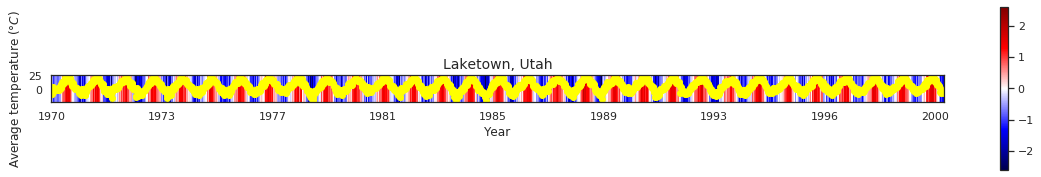

In [90]:
## Plot climate stripes at specified frequency and station
plot_stripes(df_ut[(df_ut.index.year >= 1970) & (df_ut.index.year <= 2000)], station_name = 'Laketown, Utah', tunit = 'W', plot_tseries = 'y')